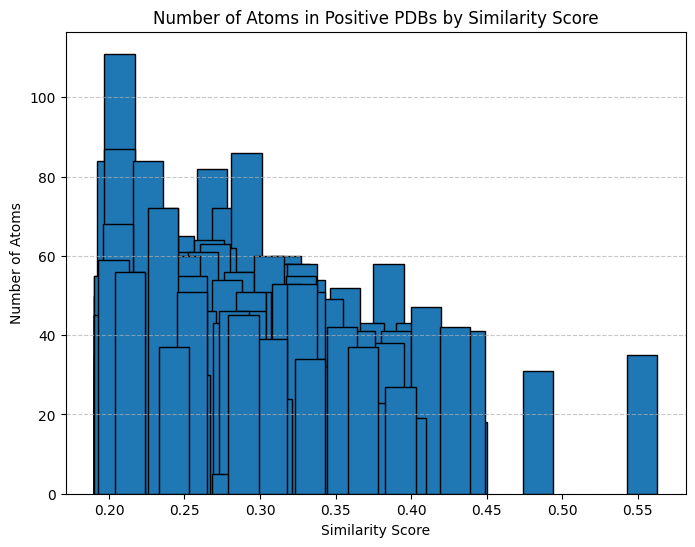

In [26]:
import os
import re
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
import seaborn as sns
import pandas as pd

# Directory containing pdb files
directory = "filtered-pdbs-distinct-5A/unlabeled"

# Prepare data lists
similarity_scores = []
atom_counts = []

parser = PDBParser(QUIET=True)

for filename in os.listdir(directory):
    if filename.endswith(".pdb") and "positive" in filename:
        # Extract similarity score from filename using regex
        match = re.search(r"-positive-([0-9]*\.?[0-9]+)", filename)
        if match:
            similarity = float(match.group(1))

            # Parse PDB file to count atoms
            structure = parser.get_structure("pdb", os.path.join(directory, filename))
            atoms = list(structure.get_atoms())
            atom_count = len(atoms)

            similarity_scores.append(similarity)
            atom_counts.append(atom_count)

# Plot histogram
plt.figure(figsize=(8,6))
plt.bar(similarity_scores, atom_counts, width=0.02, edgecolor='black')
plt.xlabel("Similarity Score")
plt.ylabel("Number of Atoms")
plt.title("Number of Atoms in Positive PDBs by Similarity Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [27]:
def _pdb_scores_by_base7(pdb_dir):
    """Map first 7 chars of PDB base name -> similarity score parsed from filename."""
    scores = {}
    for fname in os.listdir(pdb_dir):
        if fname.endswith(".pdb"):
            m = re.match(r"(.+)-([0-9]*\.?[0-9]+)\.pdb", fname)  # e.g., 1ZHY-f3-0.000.pdb
            if m:
                base7 = m.group(1)[:7]
                scores[base7] = float(m.group(2))
    return scores

def plot_similarity_per_group_to_ax(csv_path, pdb_dir, ax, title,
                                    id_col=None, filename_col="filename",
                                    show_x=True):
    """
    If id_col is given (e.g., 'protein_id' for 3DCNN), use it (first 7 chars).
    Otherwise, derive base7 from the basename of filename_col.
    """
    df = pd.read_csv(csv_path)
    pdb_scores = _pdb_scores_by_base7(pdb_dir)

    if id_col is not None:
        base7 = df[id_col].astype(str).str[:7]
    else:
        base7 = df[filename_col].astype(str).apply(lambda x: os.path.basename(x)[:7])

    df = df.assign(similarity_score=base7.map(pdb_scores)).dropna(subset=["similarity_score"])

    order = ["StrongNegative", "PseudoNegative", "PseudoPositive", "StrongPositive"]
    sns.boxplot(x="percentile_label", y="similarity_score", data=df, order=order, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Overlap Score")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Control x-axis visibility (labels + tick labels)
    if show_x:
        ax.set_xlabel("Percentile Label")
        ax.tick_params(axis='x', rotation=15)
    else:
        ax.set_xlabel("")
        ax.tick_params(axis='x')
        ax.set_xticklabels([])  # hide category names but keep plotting order


In [28]:
# === Paths ===
csv_gnn = "../../../Models/Cholesterol/GNN/GNN-5A_Exp1/NewResults/TestUnlabeledCaptureRates.csv"  # Change to your CSV path
pdb_dir = "filtered-pdbs-distinct-5A/unlabeled"  # Change to your PDB directory

In [29]:
# === Paths ===
csv_gcn = "../../../Models/Cholesterol/GCN/GCN-5A_Exp1/Results/TestUnlabeledCaptureRates.csv"  # Change to your CSV path
pdb_dir = "filtered-pdbs-distinct-5A/unlabeled"  # Change to your PDB directory

In [30]:
# === Paths ===
csv_gat = "../../../Models/Cholesterol/GAT/GATModels-5A_exp1v2/NewResults/TestUnlabeledCaptureRates.csv"  # Change to your CSV path
pdb_dir = "filtered-pdbs-distinct-5A/unlabeled"  # Change to your PDB directory

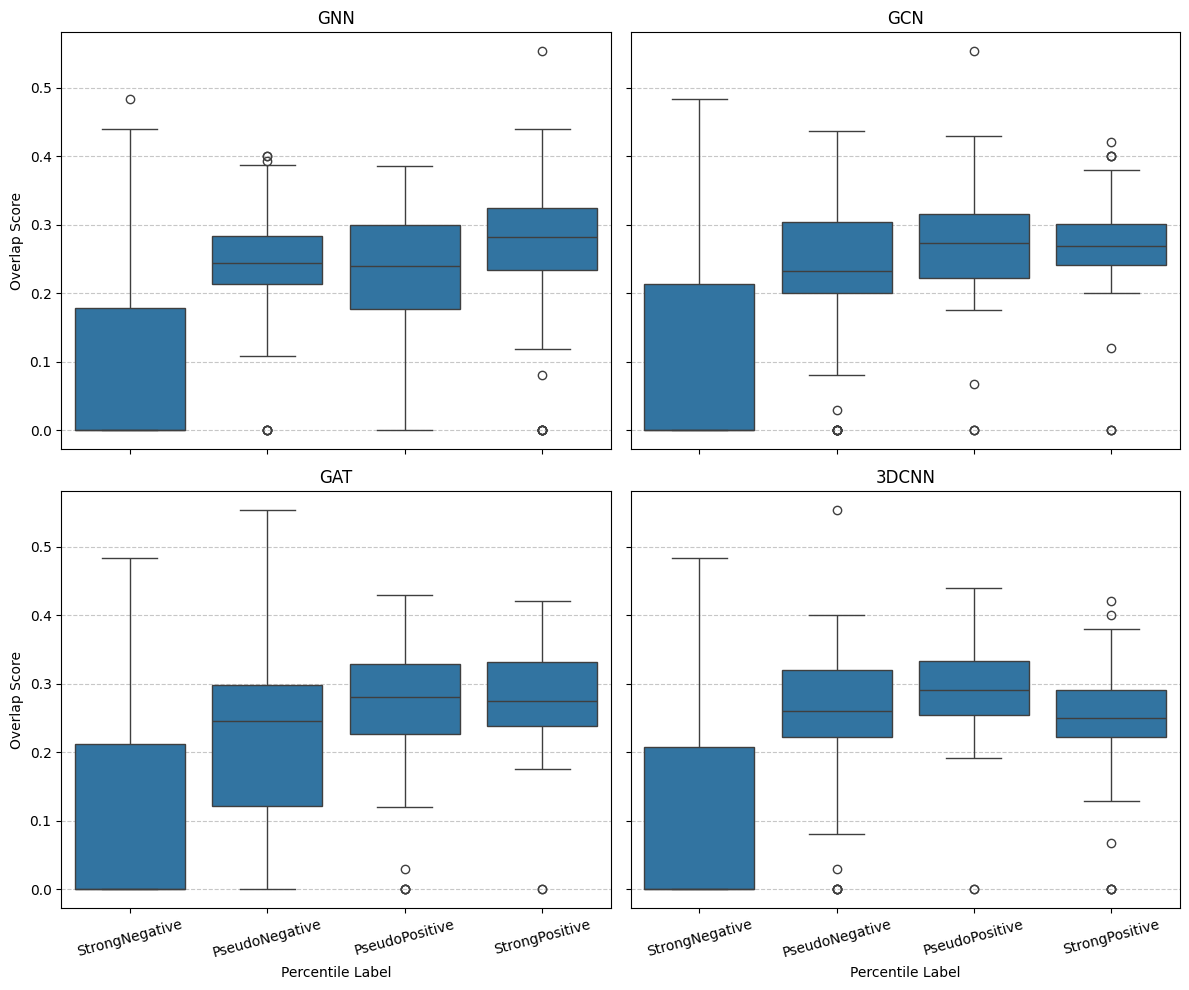

In [31]:
# === Paths ===
csv_cnn = "../../../Models/Cholesterol/3DCNN/3DCholesterolModels-5A_exp1/NewResults/TestUnlabeledCaptureRates_labeled.csv"  # Change to your CSV path
pdb_dir = "filtered-pdbs-distinct-5A/unlabeled"  # Change to your PDB directory

labels = ["GNN", "GCN", "GAT", "3DCNN"]
paths  = [csv_gnn, csv_gcn, csv_gat, csv_cnn]
idcols = [None,    None,    None,    "protein_id"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
for i, (ax, label, path, idc) in enumerate(zip(axes.flatten(), labels, paths, idcols)):
    show_x = i >= 2  # only bottom row shows x labels/ticks
    plot_similarity_per_group_to_ax(path, pdb_dir, ax, label, id_col=idc, show_x=show_x)

plt.tight_layout()
plt.show()